In [1]:
%matplotlib inline
import zipfile
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

# 数据

## 加载数据

In [2]:
# 用相对路径指定zip文件
zip_path = '/home/ly/miniconda3/envs/shiwei/data/hotdog.zip'
# 打开zip文件
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # 解压到当前目录
    zip_ref.extractall('/home/ly/miniconda3/envs/shiwei/data')

## 数据预处理（数据增广）

In [3]:
# 使用RGB通道的均值和标准差，以标准化每个通道
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# [0.485, 0.456, 0.406] 是 RGB 通道的平均值。[0.229, 0.224, 0.225] 是 RGB 通道的标准差，尤其是那些在 ImageNet 数据集上训练的模型，因为这些值是 ImageNet 数据集RGB通道的平均值和标准差

train_augs = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
                                             torchvision.transforms.RandomHorizontalFlip(),
                                             torchvision.transforms.ToTensor(),
                                             normalize])

test_augs = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                            torchvision.transforms.CenterCrop(224),
                                            torchvision.transforms.ToTensor(),
                                            normalize])

## 数据处理为迭代器录入（在此处设置batch_size）

In [4]:
train_imgs = torchvision.datasets.ImageFolder(root='/home/ly/miniconda3/envs/shiwei/data/hotdog/train',transform=train_augs)
test_imgs = torchvision.datasets.ImageFolder(root='/home/ly/miniconda3/envs/shiwei/data/hotdog/test',transform=test_augs)

In [5]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_imgs, batch_size=batch_size)

# 神经网络设置
- 预训练无需设置，自己从零开始训练需要设置

# 训练过程设置（两种函数，很重要！）

In [6]:
def train(net, train_iter, test_iter, learning_rate, num_epochs, T_max): 
    """用GPU训练模型，模型使用Adam，损失函数是交叉熵，学习率调度器使用余弦退火，采用多GPU设置模型(能用尽用)"""
    
    '''权重初始化'''
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    
    '''设置损失函数'''
    loss = nn.CrossEntropyLoss()# 如果后面是l.backward，此处什么都不写，如果后面是l.sum.backward，此处加入reduction=‘None’
    
    '''设置学习率优化器及调取器'''
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    # 定义一个周期的迭代次数
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)
    # 定义余弦退火的学习率调度器
    
    '''设置动图生成函数以及计数器'''
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'],ylim=[0,1])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer= d2l.Timer()
    
    '''设置多个GPU并行计算，模型的参数会在一个主GPU（这里是 devices[0]）上进行合并和更新
    每次训练迭代后，来自所有GPU的梯度会被汇总到这个主GPU上，并更新模型的参数。'''
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    '''训练过程'''
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)# 训练损失之和，训练准确率之和，样本数，预测数
        # 如果最后一个批次的大小小于其他批次，样本数量会少于预测数量。通过分别跟踪这两个数量，可以更准确地计算损失和准确率等度量指标，从而对模型的性能做出更准确的评估。
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            if isinstance(X, list):
                X = [x.to(devices[0]) for x in X]
            else:
                X = X.to(devices[0])
            y = y.to(devices[0])
            net.train()
            optimizer.zero_grad()
            y_hat= net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * y.shape[0], d2l.accuracy(y_hat, y), y.shape[0], y.numel())
                #此处X.shape[0]与y.shape[0]效果一样，均是样本数
            timer.stop()
            if (i + 1) % (len(train_iter) // 5) == 0 or i == len(train_iter) - 1:
                animator.add(epoch + (i + 1) / len(train_iter), (metric[0] / metric[2], metric[1] / metric[3], None))
                # 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, 训练精度{metric[1] / metric[3]:.3f}, 测试精度{test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec,平均批次时间 {timer.sum() / num_epochs:.3f} sec',f'在{str(devices)}')

In [7]:
def train_fine_tuning(net, train_iter, test_iter, learning_rate, num_epochs, param_group=True):
    """用GPU训练预训练，模型使用SGD，损失函数是交叉熵，学习率为固定学习率，采用多GPU设置模型(能用尽用)，对于fc层使用单独的学习率
    此处未进行权重初始化是因为在进入此函数封装之前，会对fc层进行单独权重初始化"""
    
    '''设置损失函数'''
    loss = nn.CrossEntropyLoss()# 如果后面是l.backward，此处什么都不写，如果后面是l.sum.backward，此处加入reduction=‘None’
    
    '''设置分类层与特征提取层不一样的学习率优化器'''
    # 如果param_group=True，输出层中的模型参数将使用十倍的学习率，其他层学习率保持低学习率
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        optimizer = torch.optim.SGD([{'params': params_1x},{'params': net.fc.parameters(),'lr': learning_rate * 10}],lr=learning_rate, weight_decay=0.001)
    else:
        optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate,weight_decay=0.001)
   
    '''设置动图生成函数以及计数器'''
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'],ylim=[0,1])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer= d2l.Timer()
    
    '''设置多个GPU并行计算，模型的参数会在一个主GPU（这里是 devices[0]）上进行合并和更新
    每次训练迭代后，来自所有GPU的梯度会被汇总到这个主GPU上，并更新模型的参数。'''
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    
    '''训练过程'''
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)# 训练损失之和，训练准确率之和，样本数，预测数
        # 如果最后一个批次的大小小于其他批次，样本数量会少于预测数量。通过分别跟踪这两个数量，可以更准确地计算损失和准确率等度量指标，从而对模型的性能做出更准确的评估。
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            if isinstance(X, list):
                X = [x.to(devices[0]) for x in X]
            else:
                X = X.to(devices[0])
            y = y.to(devices[0])
            net.train()
            optimizer.zero_grad()
            y_hat= net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * y.shape[0], d2l.accuracy(y_hat, y), y.shape[0], y.numel())
                #此处X.shape[0]与y.shape[0]效果一样，均是样本数
            timer.stop()
            if (i + 1) % (len(train_iter) // 5) == 0 or i == len(train_iter) - 1:
                animator.add(epoch + (i + 1) / len(train_iter), (metric[0] / metric[2], metric[1] / metric[3], None))
                # 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, 训练精度{metric[1] / metric[3]:.3f}, 测试精度{test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec,平均批次时间 {timer.sum() / num_epochs:.3f} sec',f'在{str(devices)}')

### 开始训练

In [8]:
pretrained_net = torchvision.models.resnet18(pretrained=False)

/home/ly/miniconda3/envs/shiwei/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ly/miniconda3/envs/shiwei/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
finetune_net = torchvision.models.resnet18(pretrained=True).cuda()
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2).cuda()
nn.init.xavier_uniform_(finetune_net.fc.weight)

/home/ly/miniconda3/envs/shiwei/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[-0.1022, -0.0653, -0.0565,  ..., -0.0551,  0.0903,  0.0081],
        [-0.0344,  0.0773, -0.0048,  ...,  0.0617,  0.0075,  0.0437]],
       device='cuda:0', requires_grad=True)

loss 0.358, 训练精度0.838, 测试精度0.861
1461.9 examples/sec,平均批次时间 1.368 sec 在[device(type='cuda', index=0), device(type='cuda', index=1)]


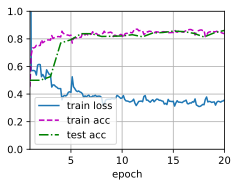

In [10]:
train(pretrained_net, train_iter, test_iter, learning_rate=0.1, num_epochs=20, T_max=20)

loss 0.203, 训练精度0.916, 测试精度0.926
1570.3 examples/sec,平均批次时间 1.274 sec 在[device(type='cuda', index=0), device(type='cuda', index=1)]


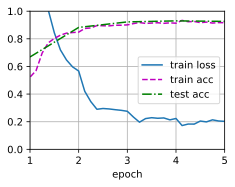

In [11]:
train_fine_tuning(finetune_net, train_iter, test_iter, learning_rate=5e-3, num_epochs=5, param_group=True)